# Neuro-GAN: Unified Generative Adversarial Networks for Neural Cells generation

In [ ]:
!pip install neurom==2.0.2
!git clone https://github.com/diphosphine/data.git

     |████████████████████████████████| 3.2MB 5.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.8MB 32.4MB/s 
  Created wheel for neurom: filename=neurom-2.0.2-cp37-none-any.whl size=97657 sha256=b26b7b80e131c0e7bdc9b667e3dd5e849e435f4657481c91d184e71183757f65
  Stored in directory: /root/.cache/pip/wheels/b1/4e/29/6b0c2778659a6e49b585c4277ee1ed7bb30acd9adcb0a25d6c
Successfully built neurom
Cloning into 'data'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


### Load Dataset

In [ ]:
import zipfile
neuroZip = zipfile.ZipFile("data/ddtx.zip", "r")
for fileM in neuroZip.namelist(): 
    neuroZip.extract(fileM, "data/train")

neuroZip.close()

### Test package *neurom*

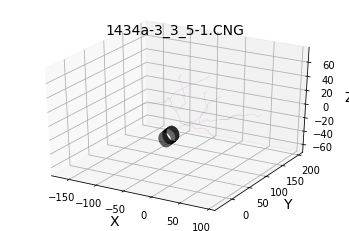

In [ ]:
import neurom as nm
from neurom import viewer

nrn = nm.load_neuron('data/train/CNG version/1434a-3_3_5-1.CNG.swc')
fig, ax = viewer.draw(nrn, mode='3d')
fig.show()

def showSwc(filePath):
  nrn = nm.load_neuron(filePath)
  fig, ax = viewer.draw(nrn, mode='3d')
  fig.show()

### Method to translate .swc file to matrix and inverse

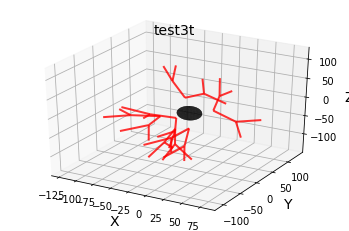

In [ ]:
import numpy as np

#generate a list, each element is a line in .swc files
def matrixToSwc(matrix):
  index=1
  fs=[]
  for subMatrix in matrix:
    thisLine=str(index)+" "+str(int(subMatrix[4]))+" "+str(subMatrix[0])+" "+str(subMatrix[1])+" "+str(subMatrix[2])+" "+str(subMatrix[3])+" "
    fa=np.where(subMatrix[5:]==1)[0].tolist()
    if len(fa)==0:
      thisLine+="-1"
    elif len(fa)==1:
      thisLine+=str(fa[0]+1)+""
    else:
      raise ValueError("Invalid matrix.")
    thisLine+="\n"
    fs.append(thisLine)
    index+=1
  return fs

#generate a matrix, each vector is the node in cells
def swcToMatrix(swc):
  fm=[]
  for i in swc:
    thisCell=list(map(lambda x: float(x),i.strip("\n").split(" ")))
    thisVector=np.zeros(5+len(swc))
    thisVector[0]=float(thisCell[2])
    thisVector[1]=float(thisCell[3])
    thisVector[2]=float(thisCell[4])
    thisVector[3]=float(thisCell[5])
    thisVector[4]=float(thisCell[1])
    thisVector[5+int(thisCell[6])-1]=1
    fm.append(thisVector)
  fMatrix=np.array(fm)
  return fMatrix
  
with open("data/test3.swc","r") as fh:
  allLines = fh.readlines() 

matrix=[]
for i in allLines[1:]:
  thisVector=np.fromstring(i.strip("\n"),dtype=float,sep=",")
  matrix.append(thisVector)
firstMatrix=matrix

with open("data/test3t.swc","w") as fh:
  fh.writelines(matrixToSwc(np.array(matrix)))

showSwc("data/test3t.swc")

### Load Dataset of Neural cells

In [ ]:
import os

def filesToRawMatrix(addr):
  allfiles=[]
  files= os.listdir(addr) 
  for file in files:
    with open(addr+"/"+file,"r") as fh:
      allLines = fh.readlines() 

    ind=0
    for i in range(len(allLines)):
      if "#" not in allLines[i] and allLines[i]!="\n" and "X" not in allLines[i]:
        break
      ind+=1

    matrix=[]
    for i in allLines[ind:]:

      thisVector=np.fromstring(i.strip("\n"),dtype=float,sep=" ")
      matrix.append(thisVector)

    allfiles.append(matrix)
  return allfiles
allfiles=filesToRawMatrix("data/train/CNG version")

In [ ]:
rawDataset=[]
def extractLine(swcMatrix):
  extractRes=[]

  branchMap={}
  for node in swcMatrix:
    if node[-1] in branchMap.keys():
      branchMap[node[-1]].append(node[0])
    else:
      branchMap[node[-1]]=[node[0]]

  iterStack=[1.0]
  while len(iterStack)!=0:
    thisBranch=iterStack.pop()
    children=branchMap[thisBranch]
    for childNode in children:
      nodeStep=childNode
      thisBranchRes=[thisBranch]
      while nodeStep in branchMap.keys() and len(branchMap[nodeStep])==1:
        thisBranchRes.append(nodeStep)
        nodeStep=branchMap[nodeStep][0]
      thisBranchRes.append(nodeStep)
      if nodeStep in branchMap.keys():
        iterStack.append(nodeStep)
      extractRes.append(thisBranchRes)
  
  finalRes=[]
  for oneBranch in extractRes:
    thisBranch=[]
    if not swcMatrix[int(oneBranch[-1])-1][1]==1.0:
      for i in oneBranch:
        thisBranch.append(swcMatrix[int(i)-1][2:5])
      finalRes.append(thisBranch)

  return finalRes
    




def prepareDataset(allfiles):
  res=[]
  for i in allfiles:
    res+=extractLine(i)
  return res

#get the dataset
extractAll=prepareDataset(allfiles)

In [ ]:
len(extractAll)

11035

[0, -0.02577270894112875, -0.050322358287285714, -0.0672664724694336, -0.07076776263098018, 0] [0, -0.10629896083219935, 0.0435325649855101, -0.05177573481763976, -0.07105444399733502, 0] [-1, -0.26148573634633976, 0.22752987033657818, 0.7148098960288212, 0.8273404521315472, 1]


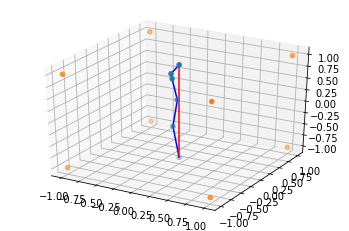

In [ ]:
#map position into [-1,1]*3 range
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def createNewCoor(oriVector):
    oriVectorNorm=np.linalg.norm(oriVector)
    xAxis=np.zeros(3)
    xAxis[0],xAxis[2]=1,-oriVector[0]/oriVector[2]
    xAxis=oriVectorNorm*xAxis/np.linalg.norm(xAxis)
    yAxis=np.zeros(3)
    yAxis[0],yAxis[1],yAxis[2]=oriVector[0]/oriVector[2],(oriVector[0]**2+oriVector[2]**2)/(-oriVector[1]*oriVector[2]),1
    yAxis=oriVectorNorm*yAxis/np.linalg.norm(yAxis)
    return xAxis/2,yAxis/2,oriVector

#generalize the coordination of each nodes on a line
def branchGeneralization(branches):
  res=[]
  for branch in branches:
    newBranch=[]
    oriVector=branch[-1]-branch[0]
    xa,ya,za=createNewCoor(oriVector)
    xaNorm,yaNorm,zaNorm=np.linalg.norm(xa),np.linalg.norm(ya),np.linalg.norm(za)
    newBranch.append(np.array([0,0,-1]))

    otherNodes=branch[1:-1]
    ind=1
    for subNode in otherNodes:
      subVector=subNode-branch[0]
      zz=((subVector@za/zaNorm)-zaNorm/2)/(zaNorm/2)
      xx=(subVector@xa/xaNorm)/xaNorm
      yy=(subVector@ya/yaNorm)/yaNorm
      newNode=np.zeros(3)
      newNode[0],newNode[1],newNode[2]=xx,yy,zz
      newBranch.append(newNode)
    newBranch.append(np.array([0,0,1]))
    res.append(newBranch)
  return res


#test
fig3 = plt.figure()
ax3 = plt.axes(projection='3d')

xl,yl,zl=[],[],[]

extractSamples=extractLine(allfiles[1])

extractSample=0
for i in range(len(extractSamples)):
  extractSample=extractSamples[i]
  if len(extractSample)>2:
    break
tp=branchGeneralization([extractSample])

for i in tp[0]:
  xl.append(i[0])
  yl.append(i[1])
  zl.append(i[2])

print(xl,yl,zl)
ax3.plot3D(xl, yl, zl, 'blue')
ax3.plot3D([xl[0],xl[-1]], [yl[0],yl[-1]], [zl[0],zl[-1]], 'red')

ax3.scatter3D(xl, yl, zl, 'green')
ax3.scatter3D([1,1,1,1,-1,-1,-1,-1], [1,1,-1,-1,1,1,-1,-1], [1,-1,1,-1,1,-1,1,-1], 'yellow')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


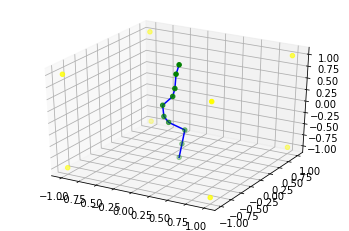

In [ ]:
#take and filter the dataset
generalizedDataset=branchGeneralization(extractAll)

def delNodes(node,length):
  points=node[:]
  while len(points)>length:
    disList=[]
    for i in range(2,len(points)):
      disList.append([[i-2,i],np.linalg.norm(points[i]-points[i-2])])
    disList.sort(key=lambda x:x[1])
    delKey=(disList.pop(0))[0][0]+1
    del points[delKey]
  return points



  

def reSampleDataset(nDs,length):
  newSamples=[]
  for sample in nDs:
    hasNan=False
    for point in sample:
      #filter nan out
      if np.isnan(point.sum()):
        hasNan=True
        break
    if len(sample)>=length and hasNan==False:
      newSamples.append(delNodes(sample,length))
  return newSamples



def filterDataset(gDs,length):
  newDataset=[]
  for line in gDs:
    filteredNodes=[]
    standardData=True
    for node in line:
      if 1<node[0] or node[0]<-1 or 1<node[1] or node[1]<-1 or 1<node[2] or node[2]<-1:
        standardData=False
        break
      thisNode=np.zeros(3)
      thisNode=node[:]
      filteredNodes.append(thisNode)
    if standardData:
      newDataset.append(filteredNodes)
  resLists=reSampleDataset(newDataset,length)
  resMatrix=np.zeros(len(resLists)*(length)*3).reshape(len(resLists),(length),3)
  for vecInd in range(len(resLists)):
    resMatrix[vecInd][:]=resLists[vecInd][:]
  return resMatrix

      



filteredDataset=filterDataset(generalizedDataset,10)

fig6 = plt.figure()
ax6 = plt.axes(projection='3d')

xl,yl,zl=[],[],[]

for line in filteredDataset[0:1]:
  for i in line:

    xl.append(i[0])
    yl.append(i[1])
    zl.append(i[2])

ax6.plot3D(xl, yl, zl, c='blue')
ax6.scatter3D(xl, yl, zl, c='green')
ax6.scatter3D([1,1,1,1,-1,-1,-1,-1], [1,1,-1,-1,1,1,-1,-1], [1,-1,1,-1,1,-1,1,-1], c='yellow')

In [ ]:
len(filteredDataset)

4781

In [ ]:
filteredDataset[0]

array([[ 0.        ,  0.        , -1.        ],
       [ 0.01569745,  0.0426819 , -0.71523585],
       [ 0.03604616,  0.07806523, -0.41885417],
       [-0.08370437, -0.11028916, -0.19048372],
       [-0.11561579, -0.16907136, -0.04072704],
       [-0.11858236, -0.19126541,  0.20961562],
       [-0.00524446, -0.1438768 ,  0.40499043],
       [ 0.01668059, -0.13017244,  0.5706984 ],
       [ 0.00565102, -0.08289076,  0.84510992],
       [ 0.        ,  0.        ,  1.        ]])

###Test helper functions

In [ ]:
def compress_file(zipfilename, dirname):
    if os.path.isfile(dirname):
        with zipfile.ZipFile(zipfilename, 'w') as z:
            z.write(dirname)
    else:
        with zipfile.ZipFile(zipfilename, 'w') as z:
            for root, dirs, files in os.walk(dirname):
                for single_file in files:
                    if single_file != zipfilename:
                        filepath = os.path.join(root, single_file)
                        z.write(filepath)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


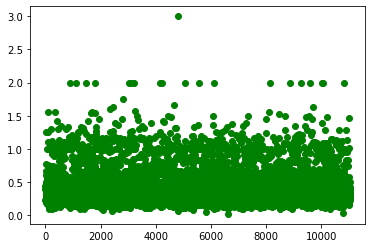

In [ ]:
countMap={}
lengthMap={}
rat=[]
ldt=[]
for i in extractAll:
  if len(i) in countMap.keys():
    countMap[len(i)]+=1
  else:
    countMap[len(i)]=1
  length=(np.linalg.norm(i[-1]-i[0]))//1
  if length in lengthMap.keys():
    lengthMap[length]+=1
  else:
    lengthMap[length]=1
  rat.append(len(i)/length)
  ldt.append(length)

LENGTH_MAP=np.array(ldt)

fig4 = plt.figure()
ax4 = plt.axes()

xl=list(range(len(rat)))

ax4.scatter(xl,rat, c='green')

In [ ]:
def evalSegment(segments):
  lengthList=[]
  angleList=[]
  for onese in segments:
    length=0
    for i in range(1,len(onese)):
      length+=np.linalg.norm(onese[i]-onese[i-1])
    lengthList.append(length)
    for i in range(1,len(onese)-1):
      vec1=onese[i]-onese[i-1]
      vec2=onese[i+1]-onese[i]
      norm1=np.linalg.norm(vec1)
      norm2=np.linalg.norm(vec2)
      angle=(vec1@vec2)/norm1/norm2
      angleList.append(np.arccos(angle)/np.pi*180)
  xstd=np.std(segments,axis=0)
  return lengthList,angleList,xstd

rll,ral,rstd=evalSegment(filteredDataset)


In [ ]:
import scipy as sp

#method to rotate the branches
def rotationMatrix(axis, theta):

    axis = axis/np.linalg.norm(axis)
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
    
def getRotateMatrix(centrePos,originPos,rotatedPos):
  originVector,rotatedVector=originPos-centrePos,rotatedPos-centrePos
  originVectorNorm,rotatedVectorNorm=originVector/np.linalg.norm(originVector),rotatedVector/np.linalg.norm(rotatedVector)
  axis=np.cross(originVectorNorm, rotatedVectorNorm)
  axis=axis.round(15)
  if (axis==np.array([0,0,0])).all():
    return np.eye(3)
  radian = np.arccos(originVectorNorm@rotatedVectorNorm)
  rm=rotationMatrix(axis,radian)

  return rm

def getRotateResult(centrePos,subNodePos,rm):

  subNodeVector=subNodePos-centrePos
  #shiftSubNodesVector=subNodesVector-np.linalg.norm(subNodesVector,axis=1).reshape(-1,1)*np.tile(shiftVector,(len(subNodesPos),1))
  shiftSubNodeVector=subNodeVector@rm
  resSubNodesPos=shiftSubNodeVector+centrePos

  return resSubNodesPos





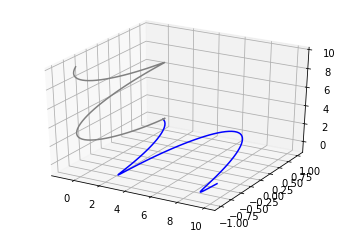

In [ ]:
from mpl_toolkits import mplot3d


fig = plt.figure()
ax = plt.axes(projection='3d')

zfinal=np.zeros(200)
xfinal=np.zeros(200)
yfinal=np.zeros(200)

zline = np.linspace(0,10, 100)
xline = np.sin(zline)
yline = np.cos(zline)

zfinal[:100]=zline
xfinal[:100]=xline
yfinal[:100]=yline

rm=getRotateMatrix(np.array([0,0,0]),np.array([1,0,0]),np.array([0,0,1]))
for i in range(100):
  xfinal[100+i],yfinal[100+i],zfinal[100+i]=getRotateResult(np.array([0,0,0]),np.array([xline[i],yline[i],zline[i]]),rm)


ax.plot3D(xfinal[100:], yfinal[100:], zfinal[100:], 'blue')
ax.plot3D(xfinal[:100], yfinal[:100], zfinal[:100], 'grey')

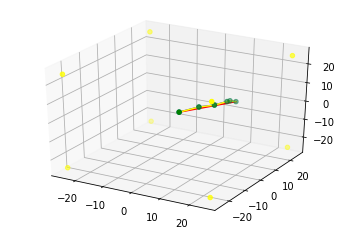

In [ ]:
#insert the generalized extra nodes into the line
def insertNodes(startPos,endPos,newNodes):
  dirVector=endPos-startPos
  xa,ya,za=createNewCoor(dirVector)
  xaNorm,yaNorm,zaNorm=np.linalg.norm(xa),np.linalg.norm(ya),np.linalg.norm(za)
  newNodeList=[]
  for node in newNodes:
    nPos=node[0]*xa+node[1]*ya+((node[2]+1)/2)*za
    newNodePos=startPos+nPos
    newNodeList.append(newNodePos)

  return newNodeList


#extractSample=extractLine(allfiles[1])[1]
tp=branchGeneralization([extractSample])

newNodes=insertNodes(extractSample[0],extractSample[-1],tp[0][1:-1])
newBranch=extractSample[0:1]+newNodes+extractSample[-1:]

fig5 = plt.figure()
ax5 = plt.axes(projection='3d')

xl,yl,zl=[],[],[]

for i in extractSample:
  xl.append(i[0])
  yl.append(i[1])
  zl.append(i[2])

ax5.plot3D(xl, yl, zl, 'blue')
ax5.plot3D([xl[0],xl[-1]], [yl[0],yl[-1]], [zl[0],zl[-1]], 'red')

ax5.scatter3D(xl, yl, zl, 'green')

xt,yt,zt=[],[],[]

for i in newBranch:
  xt.append(i[0])
  yt.append(i[1])
  zt.append(i[2])

ax5.plot3D(xt, yt, zt, 'yellow')
ax5.scatter3D(xt, yt, zt, c='green')
ax5.scatter3D([25,25,25,25,-25,-25,-25,-25], [25,25,-25,-25,25,25,-25,-25], [25,-25,25,-25,25,-25,25,-25], c='yellow')

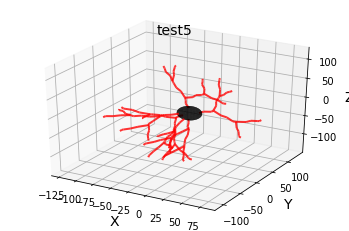

In [ ]:
def getBranches(cellMatrix):
  childrenMap={}
  ind=0
  for node in cellMatrix:
    fa=np.where(node[5:]==1)[0].tolist()
    if len(fa)==0:
      if -1 not in childrenMap:
        childrenMap[-1]=[ind]
      else:
        childrenMap[-1].append(ind)
    elif len(fa)==1:
      if fa[0] not in childrenMap:
        childrenMap[fa[0]]=[ind]
      else:
        childrenMap[fa[0]].append(ind)
    ind+=1
  newChildrenMap={}
  for node in childrenMap.keys():
    if node!=-1 and len(childrenMap[node])>1:
      childrenBranches=[]
      for child in childrenMap[node]:
        thisChild=child
        while thisChild in childrenMap.keys() and len(childrenMap[thisChild])==1:
          thisChild=childrenMap[thisChild][0]
        childrenBranches.append(thisChild)
      newChildrenMap[node]=childrenBranches
    elif node==0:
      childrenBranches=[]
      for child in childrenMap[node]:
        thisChild=child
        while thisChild in childrenMap.keys() and len(childrenMap[thisChild])==1:
          thisChild=childrenMap[thisChild][0]
        childrenBranches.append(thisChild)
      newChildrenMap[node]=childrenBranches

  return newChildrenMap

def findChildrenSet(cellTuple):
  childrenSet={}
  ind=0
  for node in cellTuple:
    fa=node[1]
    if fa not in childrenSet.keys():
      childrenSet[fa]=[ind]
    else:
      childrenSet[fa].append(ind)
    ind+=1
  return childrenSet

def findAllChildren(childrenSet,nodeInd):
    #add angles

  
  iterList=[nodeInd]
  resChildren=[]
  while len(iterList)!=0:
    thisNode=iterList.pop()
    itsChildren=childrenSet[thisNode]
    resChildren+=itsChildren
    for child in itsChildren:
      if child in childrenSet.keys():
        iterList.append(child)
  return resChildren




def applyToCell(cellMatrix,generateMethod,withAddAngle=True,withAngleRef=1):

  childrenBranches=getBranches(cellMatrix)
  nodePartMatrix=cellMatrix[:,:3]

  transferredNodes=[]
  nodePos={}
  ind=-1
  iterList=[0]
  while len(iterList)!=0:
    thisBranch=iterList.pop()

    if not thisBranch in nodePos.keys():
      transferredNodes.append((nodePartMatrix[thisBranch],ind))
      ind+=1
      nodePos[thisBranch]=ind

    parInd=nodePos[thisBranch]
    children=childrenBranches[thisBranch]
    for subend in children:
      extraNodes=insertNodes(nodePartMatrix[thisBranch],nodePartMatrix[subend],generateMethod(np.linalg.norm(nodePartMatrix[subend]-nodePartMatrix[thisBranch])))
      transferredNodes.append((extraNodes[0],parInd))
      ind+=1
      for en in extraNodes[1:]:
        transferredNodes.append((en,ind))
        ind+=1
      if subend in childrenBranches.keys():
        iterList.append(subend)

      if subend in nodePos.keys():
        print("hit your face!")

      if not subend in nodePos.keys():
        transferredNodes.append((nodePartMatrix[subend],ind))
        ind+=1
        nodePos[subend]=ind



  if withAddAngle:
  #add angle
    newCellChildrenSet=findChildrenSet(transferredNodes)

    for thisBranch in childrenBranches.keys():
      if thisBranch!=0 and thisBranch!=-1:
        thisBranchInd=nodePos[thisBranch]
        itsParInd=transferredNodes[thisBranchInd][-1]

        badCase=False
        for i in range(withAngleRef-1):
          if itsParInd==-1 or len(newCellChildrenSet[itsParInd])>1:
            badCase=True
            break
          itsParInd=transferredNodes[itsParInd][-1]
        if badCase:
          break 
        itsOldPar=(np.where(cellMatrix[thisBranch][5:]==1)[0].tolist())[0]
        itsOldParInd=nodePos[itsOldPar]

        rm=getRotateMatrix(transferredNodes[thisBranchInd][0],transferredNodes[itsOldParInd][0],transferredNodes[itsParInd][0])
        itsChildrenInd=findAllChildren(newCellChildrenSet,thisBranchInd)

        for childInd in itsChildrenInd:
          rotatedCoor=getRotateResult(transferredNodes[thisBranchInd][0],transferredNodes[childInd][0],rm)
          transferredNodes[childInd]=(rotatedCoor,transferredNodes[childInd][1])

  newMatrix=np.zeros((5+len(transferredNodes))*len(transferredNodes)).reshape(len(transferredNodes),5+len(transferredNodes))
  ind=0
  for newNode in transferredNodes:
    newMatrix[ind,0:3]=newNode[0][:]
    if ind==0:
      newMatrix[ind,3:5]=cellMatrix[0,3:5]
    else:
      newMatrix[ind,3:5]=cellMatrix[-1,3:5]
      newMatrix[ind,5+int(newNode[1])]=1
    ind+=1

  return newMatrix


def gm(l):
  newNodes=delNodes(tp[0],int(2*l))
  return tp[0][1:-1]



with open("data/test3.swc","r") as fh:
  test3Lines = fh.readlines() 

test3Matrix=[]
for i in test3Lines[1:]:
  thisVector=np.fromstring(i.strip("\n"),dtype=float,sep=",")
  test3Matrix.append(thisVector)







tCell=applyToCell(np.array(test3Matrix),gm,True,5)

with open("data/test5.swc","w") as fh:
  fh.writelines(matrixToSwc(tCell))

showSwc("data/test5.swc")

In [ ]:
#method to show a branch
def showBranch(node,generalized=True):
  figt = plt.figure()
  axt = plt.axes(projection='3d')

  xl,yl,zl=[],[],[]

  for i in node:
    xl.append(i[0])
    yl.append(i[1])
    zl.append(i[2])

  axt.plot3D(xl, yl, zl, 'blue')
  axt.plot3D([xl[0],xl[-1]], [yl[0],yl[-1]], [zl[0],zl[-1]], 'red')

  axt.scatter3D(xl, yl, zl, 'green')
  if generalized:
    axt.scatter3D([1,1,1,1,-1,-1,-1,-1], [1,1,-1,-1,1,1,-1,-1], [1,-1,1,-1,1,-1,1,-1], 'yellow')
  

### Training the dataset(DNN)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def createGenerator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(30, input_shape=(30,),activation=None))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dense(300,activation='tanh'))
  model.add(tf.keras.layers.Dense(30,activation='tanh'))
  return model

def createDiscriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(30, input_shape=(30,),activation='relu'))
  model.add(tf.keras.layers.Dense(300,activation='relu'))
  model.add(tf.keras.layers.Dense(30,activation='relu'))
  model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
  return model

dis=createDiscriminator()
gen=createGenerator()
noise=tf.random.normal([1,30])
testOut=gen(noise, training=False)
print(testOut.numpy().reshape(10,3))
testRes=dis(testOut,training=False)
print(testRes.numpy())

[[-0.42711276 -0.61025107 -0.5232204 ]
 [-0.06034348 -0.04706461  0.34630483]
 [ 0.25381225 -0.42843685 -0.42118   ]
 [ 0.60630584  0.75261563 -0.02135783]
 [-0.21249248  0.43433884 -0.5096258 ]
 [-0.5954811  -0.2386713  -0.36105683]
 [-0.5943627   0.5880127   0.33134773]
 [ 0.38462436  0.7750656   0.6455601 ]
 [-0.49383146 -0.56952304 -0.46630675]
 [-0.26826954 -0.13330919  0.3182534 ]]
[[0.48066625]]


In [ ]:
filteredDatasetDnn=filteredDataset.reshape(len(filteredDataset),30)
filteredDatasetDnn[1122].reshape(10,3)

array([[ 0.        ,  0.        , -1.        ],
       [ 0.02770628, -0.01168652, -0.8332046 ],
       [-0.03165339, -0.0553834 , -0.64448262],
       [-0.01837443, -0.06109901, -0.3457914 ],
       [-0.01612913, -0.04709834, -0.03838802],
       [-0.02915418, -0.03774516,  0.22741732],
       [-0.04033051, -0.07147982,  0.43733195],
       [-0.01005086, -0.05081659,  0.60626636],
       [-0.01768864, -0.00900909,  0.82899779],
       [ 0.        ,  0.        ,  1.        ]])

In [ ]:
BATCH_SIZE = 16
VAR_WEIGHT=tf.reshape(tf.convert_to_tensor([0,8,11,14,15,15,14,11,8,0], dtype=np.float32),[10,1])
VAR_WEIGHT/=tf.norm(VAR_WEIGHT)
BATCH_SIZE = 16
BUFFER_SIZE = 60000
trainDataset = tf.data.Dataset.from_tensor_slices(filteredDatasetDnn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
genlossRecord=[]
dislossRecord=[]

import time
def discriminatorLoss(real, fake):
  crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  realLoss = crossEntropy(tf.ones_like(real), real)
  fakeLoss = crossEntropy(tf.zeros_like(fake), fake)
  totalLoss = realLoss + fakeLoss
  return totalLoss

def generatorLoss(fake):
  crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  return crossEntropy(tf.ones_like(fake), fake)

def getOneGen(gen,filter=False):
  noise=tf.random.normal([1,30])
  testOut=tf.reshape(gen(noise, training=False),[1,10,3])
  while not (-0.1<tf.math.reduce_mean(testOut[:,0,0])<0.1 and -0.1<tf.math.reduce_mean(testOut[:,0,1])<0.1 and -0.1<tf.math.reduce_mean(testOut[:,-1,0])<0.1 and -0.1<tf.math.reduce_mean(testOut[:,-1,1])<0.1 and tf.math.reduce_mean(testOut[:,0,2])<-0.9 and 0.9<tf.math.reduce_mean(testOut[:,-1,2])):
    if filter==False:
      break
    noise=modifiedNoise(size)
    testOut=gen(noise, training=False)
  return testOut.numpy()

def calVar(samples):
  samples=tf.reshape(samples,[len(samples),10,3])
  stdRateX=tf.math.reduce_std(samples[:,:,:1],axis=0)*VAR_WEIGHT*10
  stdRateY=tf.math.reduce_std(samples[:,:,1:2],axis=0)*VAR_WEIGHT*10
  return tf.math.minimum(tf.math.reduce_mean(stdRateX),tf.math.reduce_mean(stdRateY))

@tf.function
def trainOne(oneBatch,generator,discriminator,genOpt,disOpt,withvar,varGate,varTime):
    noise = tf.random.normal([BATCH_SIZE, 30])

    with tf.GradientTape() as genTape, tf.GradientTape() as disTape:
      generatedRes = generator(noise, training=True)
      real = discriminator(oneBatch, training=True)
      fake = discriminator(generatedRes, training=True)

      genLoss = generatorLoss(fake)
      disLoss = discriminatorLoss(real, fake)
      if withvar:
        genLoss+=tf.math.maximum((varGate-calVar(generatedRes))*varTime,0)

    genGrad = genTape.gradient(genLoss, generator.trainable_variables)
    disGrad = disTape.gradient(disLoss, discriminator.trainable_variables)

    genOpt.apply_gradients(zip(genGrad, generator.trainable_variables))
    disOpt.apply_gradients(zip(disGrad, discriminator.trainable_variables))

    return genLoss,disLoss
  

def train(dataset, epochs,withvar,varGate,varTime):
  generator=createGenerator()
  discriminator=createDiscriminator()
  generatorOptimizer=tf.keras.optimizers.Adam(1e-4)
  discriminatorOptimizer = tf.keras.optimizers.Adam(1e-4)
  for epoch in range(epochs):
    start = time.time()
    tempgenl=[]
    tempdisl=[]
    for oneBatch in dataset:
      genl,disl=trainOne(oneBatch,generator,discriminator,generatorOptimizer,discriminatorOptimizer,withvar,varGate,varTime)
      tempgenl.append(genl)
      tempdisl.append(disl)
    genlossRecord.append(np.mean(tempgenl))
    dislossRecord.append(np.mean(tempdisl))

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print(getOneGen(generator))





  return generator,discriminator

  

In [ ]:
gen,dis=train(trainDataset,300,True,0.3,2.5)

Time for epoch 1 is 3.0717852115631104 sec
[[[-0.20164087 -0.35233995 -0.9105498 ]
  [ 0.17862451  0.06177088 -0.65893686]
  [-0.6152498  -0.2319541  -0.9252991 ]
  [ 0.23804297 -0.5085295  -0.3819654 ]
  [-0.65065867  0.36878827  0.7735502 ]
  [ 0.40913254  0.09306025 -0.19446819]
  [-0.03768409 -0.8100467  -0.11214963]
  [-0.5068817   0.34535757  0.96724355]
  [ 0.6668089  -0.19809484  0.7947154 ]
  [-0.02684586 -0.80512166  0.71626765]]]
Time for epoch 2 is 0.5766706466674805 sec
[[[ 0.02383559 -0.37070692 -0.65869045]
  [ 0.27537584 -0.0727024  -0.61165625]
  [-0.15846    -0.4012706  -0.66479445]
  [-0.24230151 -0.43013608 -0.46271035]
  [-0.5437021   0.17928623  0.38498095]
  [ 0.37796885  0.27356     0.07346458]
  [ 0.22905637 -0.5209598   0.10675073]
  [-0.17518811 -0.16497058  0.6748695 ]
  [ 0.26532    -0.44283012  0.676779  ]
  [-0.08442799 -0.4494946   0.6656722 ]]]
Time for epoch 3 is 0.5584888458251953 sec
[[[ 0.04884126 -0.06128505 -0.74457043]
  [ 0.10201609  0.11322191 

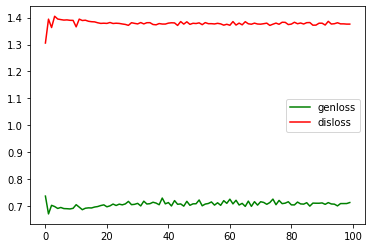

In [ ]:
fig4 = plt.figure()
ax4 = plt.axes()

xl=list(range(100))

ax4.plot(xl,genlossRecord[:100], c='green',label='genloss')
ax4.plot(xl,dislossRecord[:100], c='red',label='disloss')
ax4.legend()

[[ 0.00559073 -0.00131439 -0.99999803]
 [ 0.0074603  -0.08388138 -0.82308924]
 [-0.0273379  -0.05246229 -0.55642545]
 [-0.04946088 -0.0118866  -0.31113616]
 [-0.02445542 -0.04662511 -0.03468873]
 [ 0.01385221 -0.01194579  0.12430487]
 [ 0.03835994 -0.05154325  0.34372413]
 [-0.03854915 -0.08437447  0.5783196 ]
 [-0.04801702 -0.04561039  0.82043606]
 [-0.02109137  0.00956374  0.9999986 ]]


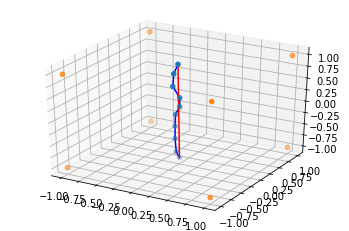

In [ ]:
genSample=getOneGen(gen)[0]
print(genSample)
showBranch(genSample)

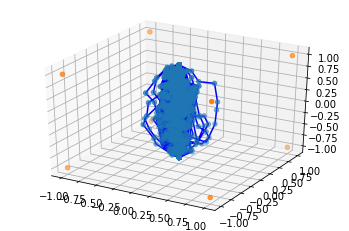

In [ ]:
genSamples=[]
for i in range(100):
  sample=getOneGen(gen,True)[0]
  sample[0]=np.array([0,0,-1])
  sample[-1]=np.array([0,0,1])
  genSamples+=sample.tolist()
showBranch(genSamples)

In [ ]:
genSamples2=[]
for i in range(4781):
  genSamples2.append(getOneGen(gen,False)[0])

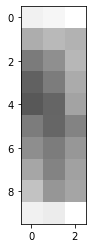

In [ ]:
plt.imshow(-np.std(genSamples2,axis=0), cmap='gray', vmin = -0.25, vmax = 0,interpolation='none')

### Training the dataset(RNN)



*   Skill One: MSE instead of CrossEntropy (discard)
*   Skill Two: Drop out prevent model vanish
*   Skill Three: sigmoid as final layer act of dis
*   Skill Four: mini batch (16)
*   Skill Five: different learning rate for dis and gen (gen:1e-4,dis:5e-4)
*   Skill Six: same nodes in rnn with input axis (3->3)
*   Skill Seven: past samples exchange
*   Skill Eight: panishment of variety (std) (weight,bias of one axis)
*   Skill Nine: Special Random Noise (discard)
*   Skill Ten: Panishment of too high prediction



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def createRnnGenerator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(3, input_shape=(10,3,),return_sequences=True))
  model.add(tf.keras.layers.Dense(3,activation='tanh'))
  model.add(tf.keras.layers.Dense(3,activation='tanh'))
  return model

def createRnnDiscriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(3, input_shape=(10,3,)))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(3,activation='tanh'))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(3,activation='tanh'))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
  return model

dis=createRnnDiscriminator()
gen=createRnnGenerator()
noise=tf.random.normal([1,10,3])
testOut=gen(noise, training=False)
print(testOut.numpy().reshape(10,3))
testRes=dis((testOut),training=False)
print(testRes.numpy())

[[ 0.01836039 -0.01571196 -0.07741253]
 [ 0.057487   -0.01491098 -0.04006439]
 [ 0.0369788  -0.02840455 -0.13677825]
 [ 0.02279215 -0.02866742 -0.15303247]
 [-0.05919085 -0.05086696 -0.3334357 ]
 [-0.08338623 -0.02170957 -0.20371723]
 [-0.08522704 -0.06393271 -0.40786487]
 [-0.0059532  -0.03172062 -0.18606296]
 [ 0.09583166 -0.02583285 -0.06551632]
 [ 0.02374825 -0.01954308 -0.08981516]]
[[0.49739152]]


In [ ]:
filteredDataset[409]

array([[ 0.00000000e+00,  0.00000000e+00, -1.00000000e+00],
       [-3.60596839e-02, -1.67242153e-01, -6.84237148e-01],
       [-5.03985395e-02, -1.74593855e-01, -4.46050575e-01],
       [ 2.23770457e-02, -1.19376026e-01, -2.67747358e-01],
       [ 4.90828120e-02, -7.39364354e-02, -8.65431600e-02],
       [ 6.75806715e-02, -5.70855013e-02,  1.36692833e-01],
       [ 5.73194537e-02, -2.56187034e-02,  3.25240311e-01],
       [ 7.87086811e-03,  8.12138339e-04,  6.25388305e-01],
       [ 1.00483487e-02, -2.00443425e-02,  8.90005542e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
BATCH_SIZE = 16
VAR_WEIGHT=tf.reshape(tf.convert_to_tensor([0,8,11,14,15,15,14,11,8,0], dtype=np.float32),[10,1])
VAR_WEIGHT/=tf.norm(VAR_WEIGHT)
BUFFER_SIZE = 60000
trainDataset = tf.data.Dataset.from_tensor_slices(filteredDataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
genlossRecord=[]
dislossRecord=[]

import time
def discriminatorLoss(real, fake):
  crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  #real=tf.map_fn(fn=lambda t: 0.5 if t>0.9 else t, elems=real)
  realLoss = crossEntropy(tf.ones_like(real), real)
  fakeLoss = crossEntropy(tf.zeros_like(fake), fake)
  totalLoss = realLoss + fakeLoss
  return totalLoss

def generatorLoss(fake):
  crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  return crossEntropy(tf.ones_like(fake), fake)

def modifiedNoise(size):
  return tf.random.normal([size, 10,3])
  #xynoise = tf.random.normal([size, 10,2])
  #znoise=tf.random.uniform([size, 10,1],minval=-1, maxval=1)
  #sortedZnoise=tf.sort(znoise,axis=-2)
  #return tf.concat([xynoise,sortedZnoise],axis=-1)

def getOneRnnGen(gen,size=1,filter=False):
  noise=modifiedNoise(size)
  testOut=gen(noise, training=False)
  while not (-0.1<tf.math.reduce_mean(testOut[:,0,0])<0.1 and -0.1<tf.math.reduce_mean(testOut[:,0,1])<0.1 and -0.1<tf.math.reduce_mean(testOut[:,-1,0])<0.1 and -0.1<tf.math.reduce_mean(testOut[:,-1,1])<0.1 and tf.math.reduce_mean(testOut[:,0,2])<-0.9 and 0.9<tf.math.reduce_mean(testOut[:,-1,2])):
    if filter==False:
      break
    noise=modifiedNoise(size)
    testOut=gen(noise, training=False)
  return testOut.numpy()

def calVar(samples):
  stdRateX=tf.math.reduce_std(samples[:,:,:1],axis=0)*VAR_WEIGHT*10
  stdRateY=tf.math.reduce_std(samples[:,:,1:2],axis=0)*VAR_WEIGHT*10
  return tf.math.minimum(tf.math.reduce_mean(stdRateX),tf.math.reduce_mean(stdRateY))

@tf.function
def trainOne(oneBatch,generator,discriminator,genOpt,disOpt,preGenRes,excRate,withvar,varGate,varTime):
    noise = modifiedNoise(BATCH_SIZE)

    with tf.GradientTape() as genTape, tf.GradientTape() as disTape:
      generatedRes = generator(noise, training=True)
      confusedGeneratedRes=tf.concat([preGenRes[:int(BATCH_SIZE*excRate)],generatedRes[:BATCH_SIZE-int(BATCH_SIZE*excRate)]],0)
      real = discriminator(oneBatch, training=True)
      fake = discriminator(confusedGeneratedRes, training=True)

      genLoss = generatorLoss(fake)
      disLoss = discriminatorLoss(real, fake)

      if withvar:
        genLoss+=tf.math.maximum((varGate-calVar(generatedRes))*varTime,0)


    genGrad = genTape.gradient(genLoss, generator.trainable_variables)
    disGrad = disTape.gradient(disLoss, discriminator.trainable_variables)

    genOpt.apply_gradients(zip(genGrad, generator.trainable_variables))
    disOpt.apply_gradients(zip(disGrad, discriminator.trainable_variables))

    return genLoss,disLoss,generatedRes
  

def train(dataset, epochs,excRate=0,withvar=False,varGate=0.3,varTime=1):
  generator=createRnnGenerator()
  discriminator=createRnnDiscriminator()
  generatorOptimizer=tf.keras.optimizers.Adam(1e-4)
  discriminatorOptimizer = tf.keras.optimizers.Adam(1e-4)
  earlyStopTime=0
  for epoch in range(epochs):
    start = time.time()
    print(getOneRnnGen(generator))

    preNoise=modifiedNoise(BATCH_SIZE)
    preGeneratedRes=generator(preNoise, training=False)


    if -0.1<tf.math.reduce_mean(preGeneratedRes[:,0,0])<0.1 and -0.1<tf.math.reduce_mean(preGeneratedRes[:,0,1])<0.1 and -0.1<tf.math.reduce_mean(preGeneratedRes[:,-1,0])<0.1 and -0.1<tf.math.reduce_mean(preGeneratedRes[:,-1,1])<0.1 and tf.math.reduce_mean(preGeneratedRes[:,0,2])<-0.9 and 0.9<tf.math.reduce_mean(preGeneratedRes[:,-1,2]):
      earlyStopTime+=1
    else:
      earlyStopTime=0
    if earlyStopTime==5:
      print("Early Stop!")
      break
    genLossList,disLossList=[],[]
    for oneBatch in dataset:
      genLoss,disLoss,_=trainOne(oneBatch,generator,discriminator,generatorOptimizer,discriminatorOptimizer,tf.random.shuffle(preGeneratedRes),excRate,withvar,varGate,varTime)
      genLossList.append(genLoss)
      disLossList.append(disLossList)
      #preGeneratedRes=tf.random.shuffle(genRes)
    print("GenLoss is {}, disLoss is {}".format(np.mean(genLoss),np.mean(disLoss)))
    genlossRecord.append(genLoss)
    dislossRecord.append(disLoss)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    





  return generator,discriminator

  

In [ ]:
gen,dis=train(trainDataset,150,0,True,0.3,2.5)

[[[ 0.05915515  0.25128216 -0.01096087]
  [-0.03146139  0.1734863   0.00198347]
  [-0.09550552  0.14245051  0.0412321 ]
  [-0.08208284  0.15089697  0.04343196]
  [ 0.01058593 -0.02092356  0.08325496]
  [-0.06903811 -0.13877466  0.0936662 ]
  [-0.11067623 -0.22767913  0.02810564]
  [-0.12128969 -0.26280415  0.03229817]
  [-0.09008026 -0.24218552  0.03198368]
  [ 0.02237284 -0.09559155  0.05561208]]]
GenLoss is 0.6078195571899414, disLoss is 1.680579423904419
Time for epoch 1 is 13.07995867729187 sec
[[[-1.4876311e-01 -2.9702446e-01  4.6253196e-04]
  [-1.0734603e-01 -2.8709072e-01 -9.8330444e-03]
  [-1.5185788e-01 -3.3967242e-01  2.1704286e-03]
  [ 5.0774857e-02 -4.6688950e-01  4.6894021e-02]
  [-4.7947399e-02 -4.3507689e-01  6.3041426e-02]
  [-1.0505437e-01 -4.5346126e-01 -3.6673988e-03]
  [-1.7866097e-01 -4.5197895e-01  7.9524547e-02]
  [-1.8892980e-01 -3.6112645e-01  4.8812319e-02]
  [-1.7412765e-01 -4.0932968e-01  3.1081066e-02]
  [-2.3254041e-01 -4.6094641e-01  1.1683950e-02]]]
GenL

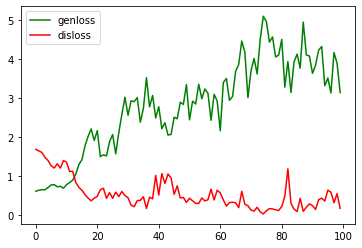

In [ ]:
fig4 = plt.figure()
ax4 = plt.axes()

xl=list(range(100))

ax4.plot(xl,genlossRecord[:100], c='green',label='genloss')
ax4.plot(xl,dislossRecord[:100], c='red',label='disloss')
ax4.legend()

[[[-0.12756222 -0.10954062 -0.93660086]
  [-0.19414702 -0.10049089 -0.8051882 ]
  [-0.22043876 -0.11148445 -0.5870526 ]
  [ 0.01365676  0.03656903 -0.58942133]
  [-0.08905465  0.00821364 -0.14396769]
  [-0.03369869  0.01965776  0.18129964]
  [ 0.04809353  0.05067865  0.43378514]
  [-0.07204743 -0.05906264  0.73611766]
  [-0.02030722 -0.06751733  0.8871022 ]
  [ 0.00910726 -0.09631465  0.96284133]]]


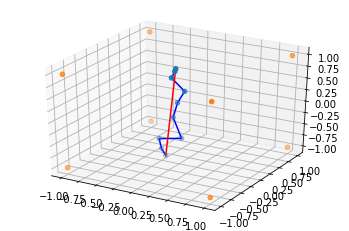

In [ ]:
genSample=getOneRnnGen(gen,filter=False)
print(genSample)
showBranch(genSample[0])


In [ ]:
noise=tf.random.normal([1,10,3])
empty=tf.ones([1,10,3])
print(dis((empty),training=False))

for oneBatch in trainDataset:
  print(dis((oneBatch),training=False))
  break

tf.Tensor([[0.00689018]], shape=(1, 1), dtype=float32)
tf.Tensor(
[[0.05952165]
 [0.94856894]
 [0.82587945]
 [0.9904784 ]
 [0.86953884]
 [0.9920164 ]
 [0.9457971 ]
 [0.88362   ]
 [0.22352168]
 [0.9782483 ]
 [0.97319746]
 [0.47730196]
 [0.7573192 ]
 [0.58739984]
 [0.87187004]
 [0.91097355]], shape=(16, 1), dtype=float32)


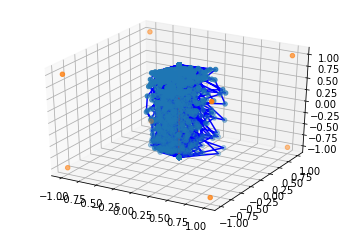

In [ ]:
genSamples=[]
for i in range(100):
  sample=getOneRnnGen(gen,filter=False)[0]
  sample[0]=np.array([0,0,-1])
  sample[-1]=np.array([0,0,1])
  genSamples+=sample.tolist()
showBranch(genSamples)

In [ ]:
genSamples2=[]
for i in range(4781):
  genSamples2.append(getOneRnnGen(gen,filter=False)[0])

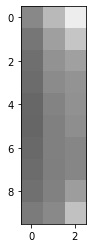

In [ ]:
plt.imshow(-np.std(genSamples2,axis=0), cmap='gray', vmin = -0.25, vmax = 0,interpolation='none')

In [ ]:
ll,al,std=evalSegment(genSamples2)

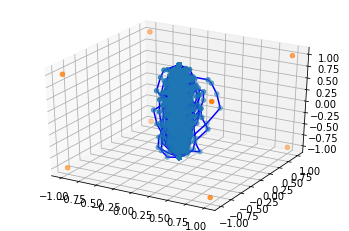

In [ ]:
oldSamples=[]
for i in range(100):
  sample=filteredDataset[i]
  sample[0]=np.array([0,0,-1])
  sample[-1]=np.array([0,0,1])
  oldSamples+=sample.tolist()
showBranch(oldSamples)

In [ ]:
gen.save("data/exp_gen")
dis.save("data/exo_dis")

INFO:tensorflow:Assets written to: data/exp_gen/assets


INFO:tensorflow:Assets written to: data/exp_gen/assets


INFO:tensorflow:Assets written to: data/exo_dis/assets


INFO:tensorflow:Assets written to: data/exo_dis/assets


In [ ]:
compress_file('data/gen.zip', 'data/exp_gen') 
compress_file('data/dis.zip', 'data/exo_dis') 

### ...Or load the pretrained Model

In [ ]:
genZip = zipfile.ZipFile("data/gen.zip", "r")
for fileM in genZip.namelist(): 
    genZip.extract(fileM, "data/t")
genZip.close()

disZip = zipfile.ZipFile("data/dis.zip", "r")
for fileM in disZip.namelist(): 
    disZip.extract(fileM, "data/t")
disZip.close()

gen=tf.keras.models.load_model("data/t/data/exp_gen")
dis=tf.keras.models.load_model("data/t/data/exo_dis")

In [ ]:
compress_file('data/gensamples.zip', 'data/gensamples') 

### Basic method for neural cell generation (Marco Palombo)

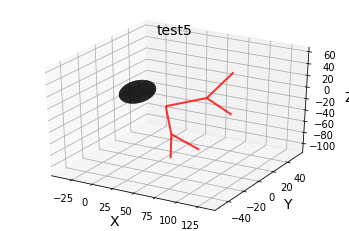

In [ ]:
from numba import njit 

@njit
def cartToSph(xx,yy,zz):

  xy = xx**2 + yy**2
  rad = np.sqrt(xy + zz**2)
  #ptsnew[:,1] = np.arctan2(np.sqrt(xy), zz) # for elevation angle defined from Z-axis down
  phi = np.arctan2(zz, np.sqrt(xy)) # for elevation angle defined from XY-plane up
  theta = np.arctan2(yy, xx)
  return theta,phi,rad



@njit
def randomChoice(n,dis):
  acc=np.random.rand()
  s=0
  for i in range(len(dis)):
    s+=dis[i]
    if s>=acc:
      return i+1
  return -1

@njit
def randomChoice2(lshrink):
  acc=np.random.rand()
  acc*=len(LENGTH_MAP)
  return (LENGTH_MAP[int(acc)]-np.mean(LENGTH_MAP))*lshrink/np.mean(LENGTH_MAP)+1


@njit
def findMean(n,dis):
  acc=0
  for i in range(len(dis)):
    acc+=dis[i]
    if acc>=0.5:
      return i+1
  return -1

@njit
def generateNeuralCell(method="Random",meanNprocess=1,sigmaNprocess=1e-6,meanLsegment=100,sigmaLsegment=1e-6,meanNbranching=3,sigmaNbranching=1e-6,meanAngle=70,dsoma=50,somaSampling=0,dbranch=1,dbranchSf=1,seedRng=1,lshrink=0):
  #Normal probability distribution of morphological parameters, pre-generate the possibility of each situation

  #These three random distribution will be the entrence of training
  n=np.arange(1,1001)
  nProcessDistrib=np.exp(-(n-meanNprocess)*(n-meanNprocess)/(2*sigmaNprocess**2))
  
  l=np.arange(1,5001)
  lSegmentDistrib=np.exp(-(l-meanLsegment)*(l-meanLsegment)/(2*sigmaLsegment**2))

  n=np.arange(1,21)
  nBranchingDistrib=np.exp(-(n-meanNbranching)*(n-meanNbranching)/(2*sigmaNbranching**2))
  maxBranching=20

  v=np.array([[0.0]])
  if method=="Random":
    u=2*np.random.rand(meanNprocess+1,1)-1
    t=np.random.rand(meanNprocess+1,1)*2*np.pi
    v=np.concatenate((np.sqrt((1-u)*(1-u))*np.cos(t),np.sqrt((1-u)*(1-u))*np.sin(t),u),axis=1)
  elif method=="Uniform":
    pass
  elif method=="Zaxis":
    pass
  else:
    raise ValueError("Unknown radiation method.")

  xdir,ydir,zdir=0,0,0
  branchNow=dbranch
  count=0
  while True:
    xdir=v[:,0:1]
    ydir=v[:,1:2]
    zdir=v[:,2:3]
    xx=v[:,0:1]*dsoma/2
    yy=v[:,1:2]*dsoma/2
    zz=v[:,2:3]*dsoma/2

    dd = np.sqrt((xx-xx.T)*(xx-xx.T)+(yy-yy.T)*(yy-yy.T)+(zz-zz.T)*(zz-zz.T))
    
    dd=dd.reshape(len(dd)*len(dd[0]))
    dd=dd[dd>0]
    
    if np.min(dd)>branchNow:
      break
    
    if count>5e3:
      branchNow=branchNow-branchNow*0.01
      count=0
    
    count+=1
  
  if branchNow<dbranch:
    print("WARNING: the radius of soma is too small compared to the radius of branch!")
    #print("New branch diameter="+str(branchNow))

  thetaPrecomp,phiPrecomp,_=cartToSph(xdir,ydir,zdir)

  cellmodelBackbone=[]
  rankInBranch=[]

  cellmodelBackbone.append({"node":np.array([0.0,0.0,0.0])})
  rankInBranch.append(0)
  
  #nProcess=np.random.choice(1000,size=1,p=nProcessDistrib)+1
  nProcess=randomChoice(1000,nProcessDistrib)
  #nProcess=nProcess[0]

  if meanNprocess==1: nProcess=1

  nBranches=0
  volume=0
  thetaList=np.zeros(10000)
  phiList=np.zeros(10000)
  lBranch=np.zeros(10000)
  dBranch=np.zeros(10000)
  branchMat=np.zeros((10000,2))
  nodeBranchMat=np.zeros((10000,max(nProcess,3)))
  nodeMat=np.zeros((10000,3))

  indNode=0
  nNodes=0
  for indProcess in range(nProcess):
    indNode+=1;
    nBranches+=1;
    theta,phi=thetaPrecomp[indProcess][0],phiPrecomp[indProcess][0]
    thetaList[indNode]=theta
    phiList[indNode]=phi

    #lSegment=np.random.choice(5000,size=1,p=lSegmentDistrib)+1
    lSegment=randomChoice(5000,lSegmentDistrib)*randomChoice2(lshrink)
    volume+=lSegment

    cellmodelBackbone.append({"node":np.array([lSegment*np.cos(phi)*np.cos(theta),lSegment*np.cos(phi)*np.sin(theta),lSegment*np.sin(phi)])})
    rankInBranch.append(1)
    cellmodelBackbone[nBranches]["branch"]=np.array([1.0,indNode])
    cellmodelBackbone[nBranches]["radius"]=np.array([branchNow/2])

    lBranch[indNode]=lSegment
    dBranch[indNode]=branchNow
    branchMat[indNode]=np.array([0,indNode])
    nNodes=indNode
    nodeBranchMat[indNode,0],nodeBranchMat[0,indProcess]=nBranches,nBranches
    nodeMat[indNode]=cellmodelBackbone[indNode]["node"].reshape(3)

  nodesWithBranchingToAssign=(np.arange(indNode+1))[np.array(rankInBranch)==1]
  temDbranch=branchNow

  maxNodeInd=0
  while len(nodesWithBranchingToAssign)!=0:
    nToAssign=len(nodesWithBranchingToAssign)

    for i in range(nToAssign):
      nodeInd=nodesWithBranchingToAssign[i]

      rank=rankInBranch[nodeInd]
      pBranch=np.sum(nBranchingDistrib[rank:])/np.sum(nBranchingDistrib)


      if np.random.rand()<pBranch:
        theta0=thetaList[nodeInd]
        phi0=phiList[nodeInd]

        #1st node
        nNodes+=1
        nBranches+=1
        rankInBranch.append(rank+1)

        #l=np.random.choice(5000,size=1,p=lSegmentDistrib)+1
        l=randomChoice(5000,lSegmentDistrib)*randomChoice2(lshrink)
        volume+=l

        deltaAngle = 0.2*np.random.randn()
        theta=theta0+0.5*meanAngle*np.pi/180+deltaAngle
        phi=phi0+0.5*meanAngle*np.pi/180;

        thetaList[nNodes]=theta
        phiList[nNodes]=phi

        
        cellmodelBackbone.append({"node":np.array([cellmodelBackbone[nodeInd]["node"][0]+l*np.cos(phi)*np.cos(theta),cellmodelBackbone[nodeInd]["node"][1]+l*np.cos(phi)*np.sin(theta),cellmodelBackbone[nodeInd]["node"][2]+l*np.sin(phi)])})
        cellmodelBackbone[nBranches]["branch"]=np.array([nodeInd,nNodes],dtype=np.float64)
        cellmodelBackbone[nBranches]["radius"]=np.array([float(branchNow)/2])

        if rank<maxBranching:
          nodesWithBranchingToAssign=np.concatenate((nodesWithBranchingToAssign,np.array([nNodes])))
        lBranch[nBranches]=l
        branchMat[nBranches]=np.array([nodeInd,nNodes])
        nodeMat[nBranches]=cellmodelBackbone[nNodes]["node"].reshape(3)
        dBranch[nodeInd]=temDbranch*dbranchSf

        if nodeInd<nProcess+1:
          nodeBranchMat[nodeInd,1]=nBranches
        else:
          nodeBranchMat[nodeInd,0]=nodeInd-1
          nodeBranchMat[nodeInd,1]=nBranches

        #2nd node
        nNodes+=1
        nBranches+=1
        rankInBranch.append(rank+1)

        #l=np.random.choice(5000,size=1,p=lSegmentDistrib)+1
        l=randomChoice(5000,lSegmentDistrib)*randomChoice2(lshrink)
        volume+=l

        theta=theta0-0.5*meanAngle*np.pi/180-deltaAngle
        phi=phi0-0.5*meanAngle*np.pi/180;

        thetaList[nNodes]=theta
        phiList[nNodes]=phi

        cellmodelBackbone.append({"node":np.array([cellmodelBackbone[nodeInd]["node"][0]+l*np.cos(phi)*np.cos(theta),cellmodelBackbone[nodeInd]["node"][1]+l*np.cos(phi)*np.sin(theta),cellmodelBackbone[nodeInd]["node"][2]+l*np.sin(phi)])})
        cellmodelBackbone[nBranches]["branch"]=np.array([nodeInd,nNodes],dtype=np.float64)
        cellmodelBackbone[nBranches]["radius"]=np.array([branchNow/2])

        if rank<maxBranching:
          nodesWithBranchingToAssign=np.concatenate((nodesWithBranchingToAssign,np.array([nNodes])))
        lBranch[nBranches]=l
        branchMat[nBranches]=np.array([nodeInd,nNodes])
        nodeMat[nBranches]=cellmodelBackbone[nNodes]["node"].reshape(3)
        dBranch[nodeInd]=temDbranch*dbranchSf

        nodeBranchMat[nodeInd,2]=nBranches

        maxNodeInd=max(nodeInd,maxNodeInd)
      else:
        nodeBranchMat[nodeInd,0]=nodeInd-1
        dBranch[nodeInd]=temDbranch*dbranchSf

        maxNodeInd=max(nodeInd,maxNodeInd)

    temDbranch*=dbranchSf
    nodesWithBranchingToAssign=nodesWithBranchingToAssign[nToAssign:]
  
  cellmodelBackbone[0]["nNodes"]=np.array([nNodes],dtype=np.float64)
  cellmodelBackbone[0]["nBranches"]=np.array([nBranches],dtype=np.float64)
  cellmodelBackbone[0]["volume"]=np.array([volume],dtype=np.float64)

  cellmodelSkeleton={}
  cellmodelSkeleton["X"]=nodeMat[:nBranches+1,0]
  cellmodelSkeleton["Y"]=nodeMat[:nBranches+1,1]
  cellmodelSkeleton["Z"]=nodeMat[:nBranches+1,2]
  cellmodelSkeleton["D"]=dBranch[:maxNodeInd+1].reshape(maxNodeInd+1)
  cellmodelSkeleton["R"]=np.ones((nBranches+1))*3

  cellmodelSkeleton["D"][0]=dsoma
  cellmodelSkeleton["R"][0]=1

  if somaSampling>0:
    pass

  dA=np.zeros((nBranches+1,nBranches+1)) 
  for i in range(1,nBranches+1): 
    dA[int(branchMat[i,0]),int(branchMat[i,1])] = 1;

  dA = dA.T

  cellMatrix=np.zeros((nBranches+1,5+nBranches+1))

  for i in range(nBranches+1):
    cellMatrix[i,0],cellMatrix[i,1],cellMatrix[i,2],cellMatrix[i,3],cellMatrix[i,4]=cellmodelSkeleton["X"][i],cellmodelSkeleton["Y"][i],cellmodelSkeleton["Z"][i],cellmodelSkeleton["D"][i],cellmodelSkeleton["R"][i]
    for j in range(nBranches+1):
      cellMatrix[i,5+j]=dA[i,j]





  return cellMatrix

import time

cellMatrix=generateNeuralCell("Random",1,1e-6,40,1e-6,3, 1e-6,70,16,0,1,1,1,0)
with open("data/test5.swc","w") as fh:
  fh.writelines(matrixToSwc(cellMatrix))

showSwc("data/test5.swc")

In [ ]:
for i in range(100):
  cellMatrix=generateNeuralCell("Random",5,1e-6,40,1e-6,3, 1e-6,70,16,0,1,1,1,0)
  testsample=matrixToSwc(cellMatrix)
  fm={}
  for i in testsample:
    k=i.strip("\n").split(" ")
    if int(k[-1]) not in fm.keys():
      fm[int(k[-1])]=[int(k[0])]
    else:
      fm[int(k[-1])].append(int(k[0]))
  fm
  angs=[]
  for j in fm.keys():
    if len(fm[j])==2:
      lf=testsample[fm[j][0]-1].strip("\n").split(" ")
      ri=testsample[fm[j][1]-1].strip("\n").split(" ")
      sl=testsample[j-1].strip("\n").split(" ")
      lxyz=np.array([float(lf[2]),float(lf[3]),float(lf[4])])
      rxyz=np.array([float(ri[2]),float(ri[3]),float(ri[4])])
      pxyz=np.array([float(sl[2]),float(sl[3]),float(sl[4])])
      lxyz=lxyz-pxyz
      rxyz=rxyz-pxyz
      ang=np.arccos((lxyz@rxyz)/(np.linalg.norm(lxyz)*np.linalg.norm(rxyz)))/(2*np.pi)*360
      angs.append(ang)
  print(np.mean(angs),np.std(angs))

80.84519185479267 14.225355755752036
83.71746172357187 16.51278080953579
89.91755432939 12.760913479378946
76.90537162444733 14.8894464921265
78.403004997718 14.154321703226293
86.16248827236514 13.300289847325843
86.22459163252165 18.614234158844486
80.64338342230539 21.05425901736401
81.25924919489047 17.785272272570506
80.90299071010651 18.204713875996248
88.06503233413903 16.424878301351804
81.49577326340378 15.670207961349485
81.2407468336332 15.08691643458573
77.11896326443916 16.10461717979202
79.3357816987685 21.906730849251943
80.79608125523868 13.026273779741366
76.57443692579201 16.847216252477647
76.35429958462491 10.814600735533647
81.47581441084967 13.698195527131181
76.87983497006289 17.61972240445401
79.7317297076357 16.04778028501577
78.63227926822704 18.710285152826188
85.33774032200922 15.973501241672558
83.83581006264646 16.850821241241352
71.71790193169203 14.82017805593151
81.67114512439113 15.509048513656213
85.38544104994773 16.230479040564063
80.73580750256858 

40.0
40.0
40.0
40.0
40.00000000000001
40.0
40.00000000000001
39.99999999999999
40.0
40.00000000000001
40.00000000000001
39.99999999999999
39.99999999999999
40.00000000000001
40.0
40.0
40.00000000000001
40.0
40.0
40.00000000000001
40.0
40.00000000000001
40.0
40.0
39.99999999999999
40.0
40.0
39.99999999999999
40.00000000000001
40.0
40.0
40.0
40.0
40.0
40.0


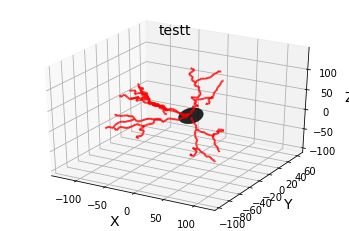

In [ ]:
def rnnApplyFunc(l):
  print(l)
  
  genSample=getOneRnnGen(gen,filter=True)
  newNodes=delNodes(genSample,max((l//80)*10,2))
  return newNodes[0][1:-1]

tCell=applyToCell(np.array(cellMatrix),rnnApplyFunc,True,3)

with open("data/testt.swc","w") as fh:
  fh.writelines(matrixToSwc(tCell))

showSwc("data/testt.swc")


### Some other attempts

In [ ]:
rawDataset=[]
def extractAllLines(swcMatrix):
  extractRes={}

  initNum=99999.0
  branchMap={}
  for node in swcMatrix:
    if node[-1] in branchMap.keys():
      branchMap[node[-1]].append(node[0])
    else:
      branchMap[node[-1]]=[node[0]]
    if node[1]!=1.0:
      initNum=min(initNum,node[1])

  maxLevel=[0]

  def extractRecursive(root,level,preres):
    maxLevel[0]=max(maxLevel[0],level)
    preres.append(root)
    if level not in extractRes.keys():
      extractRes[level]=[]
    if root in branchMap.keys():
      children=branchMap[root]
      if len(children)>1:
        extractRes[level].append(preres)
        for child in children:
          extractRecursive(child,level+1,[root])
      else:
        extractRecursive(children[0],level,preres)
    else:
      extractRes[level].append(preres)
    
  extractRecursive(initNum,0,[])
  '''maxLength=0
  for i in range(maxLevel+1):
    tempMax=0
    for segment in extractRes[i]:
      tempMax=max(tempMax,len(segment))
    maxLength+=tempMax'''

  def resampleToN(segment,n):
    if len(segment)<=n:
      return segment
    resSegment=segment[:]
    while len(resSegment)>n:
      disList=[]
      for i in range(len(resSegment)-2):
        cor1=swcMatrix[int(resSegment[i])-1][2:5]
        cor2=swcMatrix[int(resSegment[i+2])-1][2:5]
        disList.append([resSegment[i+1],np.linalg.norm(cor1-cor2)])
      disList.sort(key=lambda x:x[1])
      resSegment.remove(disList[0][0])
    return resSegment

  maxLevel=maxLevel[0]
  
  finalExtractRes=np.zeros((5*(maxLevel+1))*(2**maxLevel)*3).reshape((2**maxLevel),(5*(maxLevel+1)),3)
  finalExtractRes2=np.zeros((5*(maxLevel+1))*(2**maxLevel)).reshape((2**maxLevel),(5*(maxLevel+1)))
  for i in range(maxLevel+1):
    tempMax=0
    ind=0
    for segment in extractRes[i]:
      newSegment=resampleToN(segment,5)
      if len(newSegment)<5:
        if i==maxLevel:
          break
        else:
          return 0,0,False

      #alignment
      if i>0:
        tagP=swcMatrix[int(newSegment[0])-1][2:5]
        for preInd in range(2**(i-1)):
          if (finalExtractRes[preInd,5*i-1,:]==tagP).all():
            if (finalExtractRes[2*preInd,5*i,:]==tagP).all():
              ind=2*preInd+1
            else:
              ind=2*preInd
            break

      jind=0
      for point in newSegment:
        finalExtractRes[ind,5*i+jind,:]=swcMatrix[int(point)-1][2:5]
        finalExtractRes2[ind,5*i+jind]=point
        jind+=1
    

  return finalExtractRes,finalExtractRes2,True
    




def prepareAllDataset(allfiles):
  res=[]
  oknum=0
  for i in allfiles:
    d1,d2,va=extractAllLines(i)
    if va:
      res.append(d1)
      oknum+=1
  return res,oknum/len(allfiles)

#get the dataset
finalDs,okRatio=prepareAllDataset(allfiles)
len(finalDs)

105

In [ ]:
finalDs[4]

array([[[ 0.04,  5.27, -1.8 ],
        [-2.11, 16.09, -2.5 ],
        [-2.22, 22.87, -5.63],
        ...,
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        ...,
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        ...,
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ]],

       ...,

       [[ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        ...,
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        ...,
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,

In [ ]:
countMap={}
for i in finalDs:
  length=len(i)
  if length in countMap.keys():
    countMap[length]+=1
  else:
    countMap[length]=1

finalFilteredData=[]
for dt in finalDs:
  if len(dt)>=2:
    finalFilteredData.append(dt[:2,:10,:])




In [ ]:
len(finalFilteredData)

92

In [ ]:
#test
import matplotlib.pyplot as plt
import copy

i=finalFilteredData[0]

def addextranodes(alist,time=4):
  newlist=[]
  for i in range(1,len(alist)):
    newlist.append(alist[i-1])
    newlist.append(np.mean([alist[i],alist[i-1]]))
    newlist.append(alist[i])
  if time==1:
    return newlist
  else:
    return addextranodes(newlist,time-1)
def showLines(cell,s=100):

  fig11 = plt.figure()
  ax11 = plt.axes(projection='3d')
  for j in range(2):
    for k in range(2**j):
      xl,yl,zl=[],[],[]
      for point in cell[k,5*j:5*(j+1),:]:
        if point[0]!=0 and point[1]!=0 and point[2]!=0:
          xl.append(point[0])
          yl.append(point[1])
          zl.append(point[2])
      if len(xl)!=0:
        ax11.plot3D(xl, yl, zl, 'blue')
  ax11.scatter3D([s,s,s,s,-s,-s,-s,-s], [s,s,-s,-s,s,s,-s,-s], [s,-s,s,-s,s,-s,s,-s], 'yellow')

#ax11.plot3D(xl, yl, zl, 'blue')

#ax11.scatter3D(xl, yl, zl, 'green')

trainedDataset=[]
for i in finalFilteredData:
  k=copy.deepcopy(i)
  maxone=np.max(np.abs(k))
  for i in range(2):
    for j in range(10):
      if (k[i,j]!=np.array([0.0,0.0,0.0])).any():
        k[i,j]=(k[i,j]-k[0,0])/2/maxone+0.5
          
  ttk=np.transpose(k,axes=(1,0,2))

  trainedDataset.append(ttk)


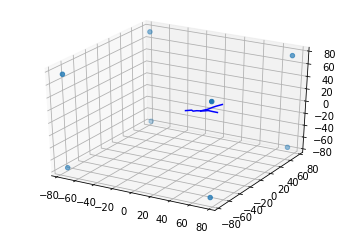

In [ ]:
showLines(finalFilteredData[44],75)

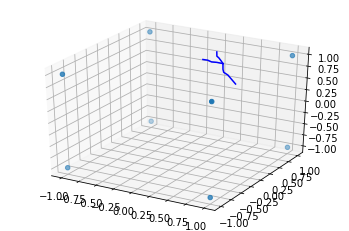

In [ ]:
def backtoPoints(flatcell):
  newcell=flatcell.reshape(10,2,3)
  return np.transpose(newcell,axes=(1,0,2))

showLines(backtoPoints(trainedDataset[11][:,:]),1)

In [ ]:
newTrainedDs=np.zeros(len(trainedDataset)*10*6).reshape(len(trainedDataset),10,2,3)
for i in range(len(trainedDataset)):
  newTrainedDs[i][:]=trainedDataset[i][:]

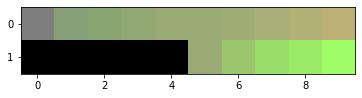

In [ ]:
plt.imshow(backtoPoints(trainedDataset[44][:,:]))

[[[[0.4972713  0.49654177 0.49732503]
   [0.50106835 0.50218713 0.5002723 ]]

  [[0.48776737 0.49658215 0.5072893 ]
   [0.4892376  0.48753443 0.50411713]]

  [[0.4994257  0.4989495  0.49537823]
   [0.4923822  0.5050935  0.4959545 ]]

  [[0.48872924 0.4987461  0.50134116]
   [0.4970309  0.49588636 0.5081743 ]]

  [[0.5015664  0.5013365  0.49473798]
   [0.49485618 0.50144327 0.48554352]]

  [[0.4984475  0.49620315 0.50023776]
   [0.49249074 0.50218344 0.50134295]]

  [[0.49687013 0.5025504  0.48656678]
   [0.492402   0.5055295  0.4979525 ]]

  [[0.48795208 0.507638   0.4974572 ]
   [0.49002606 0.4990349  0.49580434]]

  [[0.5068785  0.50003713 0.5059794 ]
   [0.5086835  0.49863613 0.4986196 ]]

  [[0.4930814  0.50016165 0.5032574 ]
   [0.50061554 0.5020482  0.4964912 ]]]]
[[0.02238327]]


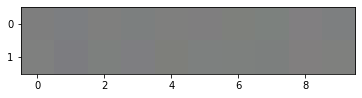

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def createCnnGenerator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(5*2*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((5, 2, 256)))
    assert model.output_shape == (None, 5, 2, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 5, 2, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 5, 2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 1), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 10, 2, 3)

    return model

def createCnnDiscriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 1), padding='same',
                                     input_shape=[10, 2, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

dis=createCnnDiscriminator()
gen=createCnnGenerator()
noise=tf.random.normal([1, 100])
testOut=gen(noise, training=False)
print(testOut.numpy())
testRes=dis((testOut),training=False)
print(testRes.numpy())
plt.imshow(backtoPoints(testOut.numpy()[0][:,:]))

In [ ]:
BATCH_SIZE = 8
BUFFER_SIZE = 60000
trainDataset = tf.data.Dataset.from_tensor_slices(newTrainedDs).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
import time
def discriminatorLoss(real, fake):
  crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  #real=tf.map_fn(fn=lambda t: 0.5 if t>0.9 else t, elems=real)
  realLoss = crossEntropy(tf.ones_like(real), real)
  fakeLoss = crossEntropy(tf.zeros_like(fake), fake)
  totalLoss = realLoss + fakeLoss
  return totalLoss

def generatorLoss(fake):
  crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  return crossEntropy(tf.ones_like(fake), fake)

def modifiedNoise(size):
  return tf.random.normal([size, 100])
  #xynoise = tf.random.normal([size, 10,2])
  #znoise=tf.random.uniform([size, 10,1],minval=-1, maxval=1)
  #sortedZnoise=tf.sort(znoise,axis=-2)
  #return tf.concat([xynoise,sortedZnoise],axis=-1)

def getOneRnnGen(gen,size=1,filter=False):
  noise=modifiedNoise(size)
  testOut=gen(noise, training=False)
  return testOut.numpy()


@tf.function
def trainOne(oneBatch,generator,discriminator,genOpt,disOpt):
    noise = modifiedNoise(BATCH_SIZE)

    with tf.GradientTape() as genTape, tf.GradientTape() as disTape:
      generatedRes = generator(noise, training=True)
      confusedGeneratedRes=generatedRes[:]
      real = discriminator(oneBatch, training=True)
      fake = discriminator(confusedGeneratedRes, training=True)

      genLoss = generatorLoss(fake)
      disLoss = discriminatorLoss(real, fake)


    genGrad = genTape.gradient(genLoss, generator.trainable_variables)
    disGrad = disTape.gradient(disLoss, discriminator.trainable_variables)

    genOpt.apply_gradients(zip(genGrad, generator.trainable_variables))
    disOpt.apply_gradients(zip(disGrad, discriminator.trainable_variables))

    return genLoss,disLoss,generatedRes
  

def train(dataset, epochs):
  generator=createCnnGenerator()
  discriminator=createCnnDiscriminator()
  generatorOptimizer=tf.keras.optimizers.Adam(1e-4)
  discriminatorOptimizer = tf.keras.optimizers.Adam(1e-4)
  for epoch in range(epochs):
    start = time.time()
    print(getOneRnnGen(generator)[0])


    genLossList,disLossList=[],[]
    for oneBatch in dataset:
      genLoss,disLoss,_=trainOne(oneBatch,generator,discriminator,generatorOptimizer,discriminatorOptimizer)
      genLossList.append(genLoss)
      disLossList.append(disLossList)
      #preGeneratedRes=tf.random.shuffle(genRes)
    print("GenLoss is {}, disLoss is {}".format(np.mean(genLoss),np.mean(disLoss)))

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    





  return generator,discriminator

In [ ]:
gen,dis=train(trainDataset,200)

流式输出内容被截断，只能显示最后 5000 行内容。
  [0.6130717  0.7842305  0.7394633 ]]

 [[0.3772457  0.7793011  0.31596577]
  [0.5056511  0.8880373  0.5011104 ]]

 [[0.4913855  0.7971661  0.33844823]
  [0.57706535 0.8557589  0.5416666 ]]]
GenLoss is 0.6823752522468567, disLoss is 1.4949332475662231
Time for epoch 39 is 0.5773358345031738 sec
[[[0.29582095 0.6388062  0.66261804]
  [0.02699658 0.02578676 0.01792541]]

 [[0.4260821  0.42094862 0.16540453]
  [0.00938424 0.01448524 0.00908467]]

 [[0.10780692 0.67432964 0.78436273]
  [0.01378343 0.00872129 0.00763771]]

 [[0.56241953 0.20641881 0.08335075]
  [0.00392631 0.01327199 0.02099678]]

 [[0.10161328 0.82672024 0.74368346]
  [0.03108296 0.01237291 0.01811743]]

 [[0.5737256  0.38922065 0.19681185]
  [0.6279663  0.97544295 0.9267124 ]]

 [[0.37641424 0.65906006 0.5422665 ]
  [0.91429573 0.96243614 0.89178795]]

 [[0.585901   0.56511843 0.27915698]
  [0.49695078 0.8250383  0.73748744]]

 [[0.39038235 0.835428   0.3667608 ]
  [0.6491372  0.8848598  0.61110

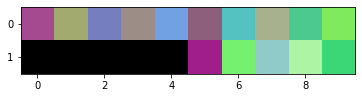

In [ ]:
plt.imshow(backtoPoints(getOneRnnGen(gen)[0]))

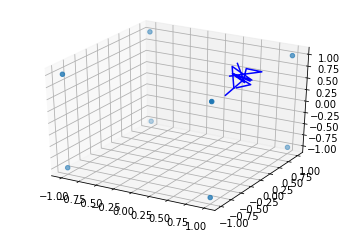

In [ ]:
gencell=backtoPoints(getOneRnnGen(gen)[0])
showLines(gencell,1)